# Imports

In [1]:
import os
import time
import datetime
import pickle
import random
from datetime import datetime

import numpy as np
import pandas as pd

from scipy.stats import yulesimon

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf

import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Conv1D, Flatten
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2, l1_l2
from keras.metrics import mean_squared_error

# fix random seed for reproducability
def fix_random(seed):
    os.environ['PYTONHASHSEED'] = '0'
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# Generate data
### &nbsp;&nbsp; *num_alphas*: number of alphas generated between (min_alpha) and (max_alpha) inclusive
### &nbsp;&nbsp; *samples_per_alpha*: number of samples (rows) for each alpha 
### &nbsp;&nbsp; *N* : number of random variates (number of samples drawn from yulesimon distribution)
### &nbsp;&nbsp; *M* : maximun value of random variates (length of input vectors == number of features)

In [2]:
def generate_data(num_alphas, samples_per_alpha, N, min_alpha=2.01, max_alpha=3.00, random_state=0):
    '''
    params:
        num_alphas: number of alphas generated between (min_alpha) and (max_alpha) inclusive
        samples_per_alpha: number of samples (rows) for each alpha 
        N: number of RV samples (columns) per row
    '''

    # fix loc at zero
    loc = 0

    X = np.empty((num_alphas * samples_per_alpha, N+1), float)

    row = 0
    
    for alpha in np.random.uniform(low=min_alpha, high=max_alpha, size=num_alphas):
        
        # generate samples (rows) for current alpha
        for i in range(samples_per_alpha):
            X[row, 0] = alpha
            X[row, 1:] = yulesimon.rvs(alpha, loc=loc, size=N, random_state=random_state)
            row += 1

    # suffle rows
    np.random.shuffle(X)

    # separate X from y
    y = X[:, 0]
    X = X[:, 1:].astype(int)

    # create a histogram (H) from (X) rows
    nbins = np.max(X)
    H = np.apply_along_axis(lambda a: np.histogram(a, bins=nbins, density=False)[0], 1, X)

    # log scale (H) rows
    logH = np.apply_along_axis(lambda a: np.log10(a+1), 1, H)

    return logH, y, nbins # (nbins == M)

# Create Model

In [3]:
def create_model(n_features, 
                 filters=32, 
                 activation='relu', 
                 init='he_uniform', 
                 batch_normalization=False, 
                 dropout=0, 
                 optimizer='adam'):

    model = Sequential()
    model.add(Conv1D(filters, 2, activation="relu", input_shape=(n_features,1)))
    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")

    return model


# Training

In [4]:
def train(X_train, y_train, X_val, y_val, filters=32, batch_size=32, random_state=0):
    model = create_model(X_train.shape[1], 
                         filters=filters, 
                         activation='relu', 
                         init=keras.initializers.HeUniform(seed=rs), 
                         batch_normalization=True, 
                         dropout=0.0)
    
    # early-stopping
    es_patience = 50
    es = EarlyStopping(monitor='val_loss', 
                        patience=es_patience, 
                        mode='min', 
                        restore_best_weights=True, 
                        verbose=0)
    
    # model checkpoint
    if not os.path.exists('models'):
        os.makedirs('models')
    date_str = datetime.now().strftime('%d-%m-%Y_%H-%M-%S')
    base_path       = 'models/yulesimon_{}'.format(date_str)
    model_path      = '{}.h5'.format(base_path)
    history_path    = '{}.history'.format(base_path)
    
    cp = ModelCheckpoint(filepath=model_path, monitor='val_loss', mode='min', save_best_only=True, verbose=0)
    
    # reduce learning-rate on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=10)
    
    # fit model
    history = model.fit(X_train, 
                        y_train, 
                        validation_data=(X_val, y_val), 
                        epochs=200, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        callbacks=[es, reduce_lr, cp], 
                        verbose=0)
    
    # save history with model
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)
    
    # load best weights from last checkpoint
    model = keras.models.load_model(model_path)
    return model, history.history

In [5]:
def plot_learning_curves(history, train_key='loss', val_key='val_loss'):
    plt.figure(figsize=(2,2))
    plt.plot(history[train_key])
    plt.plot(history[val_key])
    plt.title('learning curves')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    print('loss:', np.min(history['loss']))
    print('val_loss:', np.min(history['val_loss']))    

# Trials

In [6]:
def trial(num_alphas, samples_per_alpha, N, filters=32, batch_size=32, random_state=0, verbose=True):
    
    X, y, M = generate_data(
        num_alphas=num_alphas, 
        samples_per_alpha=samples_per_alpha, 
        N=N, 
        random_state=random_state)

    # reshape X for Conv1D
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
        test_size=0.2, random_state=random_state)

    # split train/val
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
        test_size=0.25, random_state=random_state)

    # training
    model, history = train(X_train, y_train, X_val, y_val, filters=filters, random_state=random_state)

    # predict
    y_pred = model.predict(X_test).flatten()

    mse = mean_squared_error(y_test, y_pred)
    return np.sqrt(mse), model, history, M

In [7]:
print('Processing...')
print()

a_N = np.array([])
a_sqrt_mse = np.array([])

random_states = [0, 5, 10, 17, 20]

# change N
for i in range(6, 12):

    N = 2**i

    a_N = np.append(a_N, N)

    avg_sqrt_mse = 0

    # change random state
    for rs in random_states:
        fix_random(seed=rs)
    
        sqrt_mse, m, h, M = trial(
            num_alphas=100, 
            samples_per_alpha=100, 
            N=N, 
            filters=32, 
            batch_size=32, 
            random_state=rs, 
            verbose=False)
        
        avg_sqrt_mse += sqrt_mse
        print('N = {}, M = {}, random_state = {}    =>    sqrt_mse = {}'.format(N, M, rs, sqrt_mse))

    
    avg_sqrt_mse = avg_sqrt_mse / len(random_states)
    a_sqrt_mse = np.append(a_sqrt_mse, avg_sqrt_mse)
    
    print('N = {}    =>    avg_sqrt_mse = {}'.format(N, avg_sqrt_mse))
    print()

Processing...

N = 64, M = 20, random_state = 0    =&gt;    sqrt_mse = 0.012271459214389324
N = 64, M = 5, random_state = 5    =&gt;    sqrt_mse = 0.03141392767429352
N = 64, M = 15, random_state = 10    =&gt;    sqrt_mse = 0.024119513109326363
N = 64, M = 11, random_state = 17    =&gt;    sqrt_mse = 0.030549051240086555
N = 64, M = 18, random_state = 20    =&gt;    sqrt_mse = 0.022348135709762573

N = 64    =&gt;    avg_sqrt_mse = 0.024140417389571667


N = 128, M = 46, random_state = 0    =&gt;    sqrt_mse = 0.01576901786029339
N = 128, M = 31, random_state = 5    =&gt;    sqrt_mse = 0.01412754412740469
N = 128, M = 19, random_state = 10    =&gt;    sqrt_mse = 0.014979762025177479
N = 128, M = 98, random_state = 17    =&gt;    sqrt_mse = 0.01291423849761486
N = 128, M = 30, random_state = 20    =&gt;    sqrt_mse = 0.011895996518433094

N = 128    =&gt;    avg_sqrt_mse = 0.013937311805784702


N = 256, M = 21, random_state = 0    =&gt;    sqrt_mse = 0.00587625615298748
N = 256, M = 61

# plot log(N) vs sqrt_mse

&lt;matplotlib.collections.PathCollection at 0x7f28943c2910&gt;

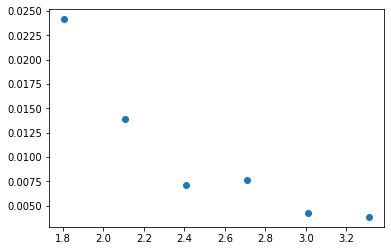

In [8]:
plt.scatter(np.log10(a_N), a_sqrt_mse)